In [6]:
import itertools
import torch
import webdataset as wds
from torch.utils.data import DataLoader
import numpy as np
import os
from dataclasses import dataclass
import tyro
from basalt.common import load_model_parameters
from basalt.vpt_lib.agent import MineRLAgent
from basalt.adapter import method_dict, FixVPTAdapter
import torch_xla.core.xla_model as xm
import torch_xla


def identity(x):
    return x


def tree_concatenate(tree1, tree2):
    if isinstance(tree1, dict) and isinstance(tree2, dict):
        return {k: tree_concatenate(tree1[k], tree2[k]) for k in tree1.keys()}
    elif isinstance(tree1, list) and isinstance(tree2, list):
        return [tree_concatenate(t1, t2) for t1, t2 in zip(tree1, tree2)]
    elif isinstance(tree1, tuple) and isinstance(tree2, tuple):
        return tuple(tree_concatenate(t1, t2) for t1, t2 in zip(tree1, tree2))
    else:
        return torch.concatenate([tree1, tree2])


def process_batches(dataloader, batch_size=512):
    for i, batch in enumerate(dataloader):
        if i == 0:
            batch[-1] = ("MineRLBasaltMakeWaterfall" in batch[-1]) * torch.ones(
                len(batch[0])
            )
            buffer = batch
        else:
            batch[-1] = ("MineRLBasaltMakeWaterfall" in batch[-1]) * torch.ones(
                len(batch[0])
            )
            buffer = tree_concatenate(buffer, batch)
        length = len(buffer[0])
        new_index = np.random.permutation(length)
        buffer = torch.utils._pytree.tree_map(lambda x: x[new_index], buffer)
        while length >= 10000:
            yield torch.utils._pytree.tree_map(lambda x: x[:batch_size], buffer)
            buffer = torch.utils._pytree.tree_map(lambda x: x[batch_size:], buffer)
            length = len(buffer[0])

    while len(buffer[0]) > 0:
        yield torch.utils._pytree.tree_map(lambda x: x[:batch_size], buffer)
        buffer = torch.utils._pytree.tree_map(lambda x: x[batch_size:], buffer)


@dataclass
class Args:
    in_model: str = "/data/foundation-model-3x.model"
    in_weights: str = "/data/foundation-model-3x.weights"
    method: str = "cls"


device = xm.xla_device()
# device = torch.device("cuda")


args = Args()
dataset = (
    wds.WebDataset(
        wds.shardlists.expand_urls(
            "/data/demonstrations/MineRLBasaltMakeWaterfall-v0/0.tar"
        )+
        wds.shardlists.expand_urls(
            "/data/demonstrations/MineRLBasaltFindCave-v0/0.tar"
        ),
        shardshuffle=True,
    )
    .shuffle(100)  # Shuffle the dataset with a buffer size of 100
    .decode()  # Decode the data
    .to_tuple("mp4.obs.npy", "mp4.actions.pyd", "__url__")  # Select specific fields
)

# Create a DataLoader to fetch data in batches of size 4
dataloader = wds.WebLoader(dataset, batch_size=None, num_workers=2)

agent_policy_kwargs, agent_pi_head_kwargs = load_model_parameters(args.in_model)

agent = MineRLAgent(
    device=device,
    policy_kwargs=agent_policy_kwargs,
    pi_head_kwargs=agent_pi_head_kwargs,
)
agent.load_weights(args.in_weights)
agent.policy.eval()
policy = agent.policy
adapter_dict = method_dict[args.method]
adapter = adapter_dict["adapter"](agent)
assert isinstance(adapter, FixVPTAdapter)
adapter.load_parameters("checkpoints/cls/epoch_10.pt")


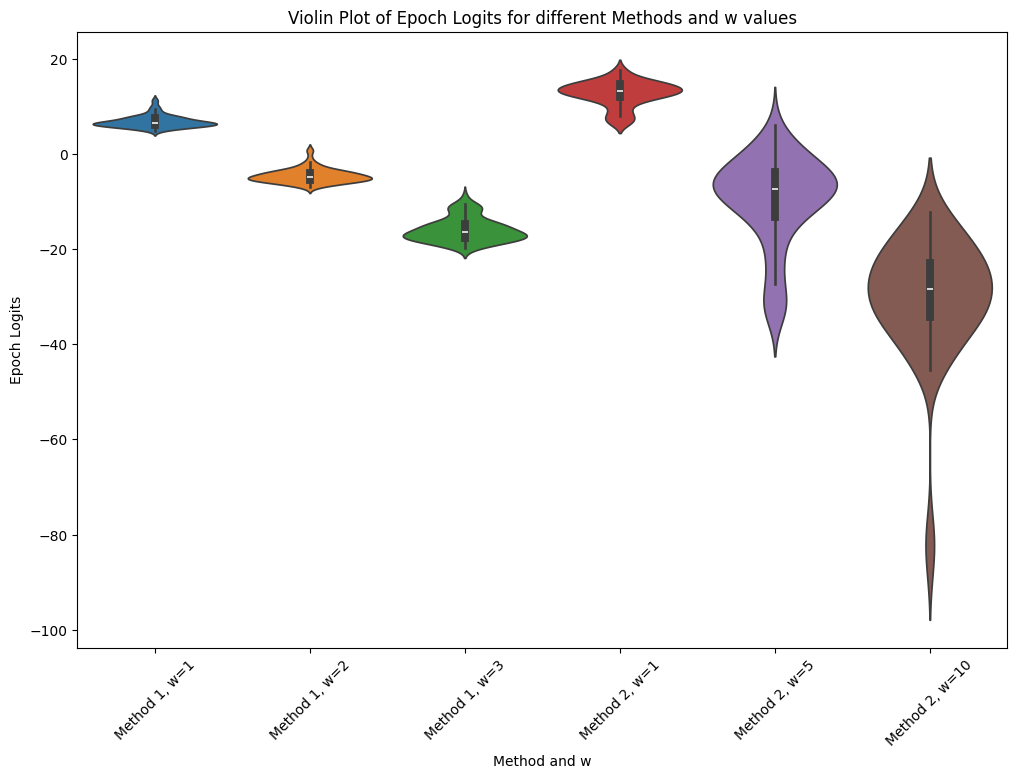

In [13]:
import itertools
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Function to accumulate epoch_logits for a given w
def accumulate_epoch_logits1(w, dataloader, device, adapter):
    epoch_logits = []
    for batch in process_batches(dataloader, batch_size=2048):
        with torch_xla.step():
            with torch.no_grad():
                batch = torch.utils._pytree.tree_map(lambda x: x.to(device), batch)
                embedding, action, label = batch
                pd = adapter.vpt_agent.policy.pi_head(embedding)
                v = adapter.head(embedding)
                input_pd = {
                    key: pd[key] + w * torch.where(label, 1, -1)[:, None, None] * v[key]
                    for key in v.keys()
                }
                embed_logit = -adapter.vpt_agent.policy.pi_head.logprob(
                    action, input_pd
                ).mean()
        epoch_logits.append(embed_logit.item())  # Append the scalar value
    return epoch_logits

def accumulate_epoch_logits2(w, dataloader, device, adapter):
    epoch_logits = []
    for batch in process_batches(dataloader, batch_size=2048):
        with torch_xla.step():
            with torch.no_grad():
                batch = torch.utils._pytree.tree_map(lambda x: x.to(device), batch)
                embedding, action, label = batch
                pd = adapter.vpt_agent.policy.pi_head(embedding)
                v = adapter.head(embedding)
                input_pd = {
                    key: pd[key] + w * torch.where(label, 1, -1)[:, None, None] * v[key].sigmoid().log()
                    for key in v.keys()
                }
                embed_logit = -adapter.vpt_agent.policy.pi_head.logprob(
                    action, input_pd
                ).mean()
        epoch_logits.append(embed_logit.item())  # Append the scalar value
    return epoch_logits


methods = [accumulate_epoch_logits1, accumulate_epoch_logits2]
method_names = ['Method 1', 'Method 2']
w_values_all = [[1, 2, 3], [1, 5, 10]]

# Accumulate epoch logits for each method and each set of w values
all_epoch_logits = {}
for method, name, w_values in zip(methods, method_names, w_values_all):
    method_logits = {}
    for w in w_values:
        method_logits[w] = method(w, dataloader, device, adapter)
    all_epoch_logits[name] = method_logits

# Combine data for plotting
data = {}
for name in method_names:
    for w in all_epoch_logits[name].keys():
        key = f'{name}, w={w}'
        data[key] = all_epoch_logits[name][w]

# Create the violin plot
plt.figure(figsize=(12, 8))
sns.violinplot(data=[data[key] for key in data.keys()])
plt.xticks(range(len(data)), list(data.keys()), rotation=45)
plt.xlabel('Method and w')
plt.ylabel('Epoch Logits')
plt.title('Violin Plot of Epoch Logits for different Methods and w values')
plt.show()


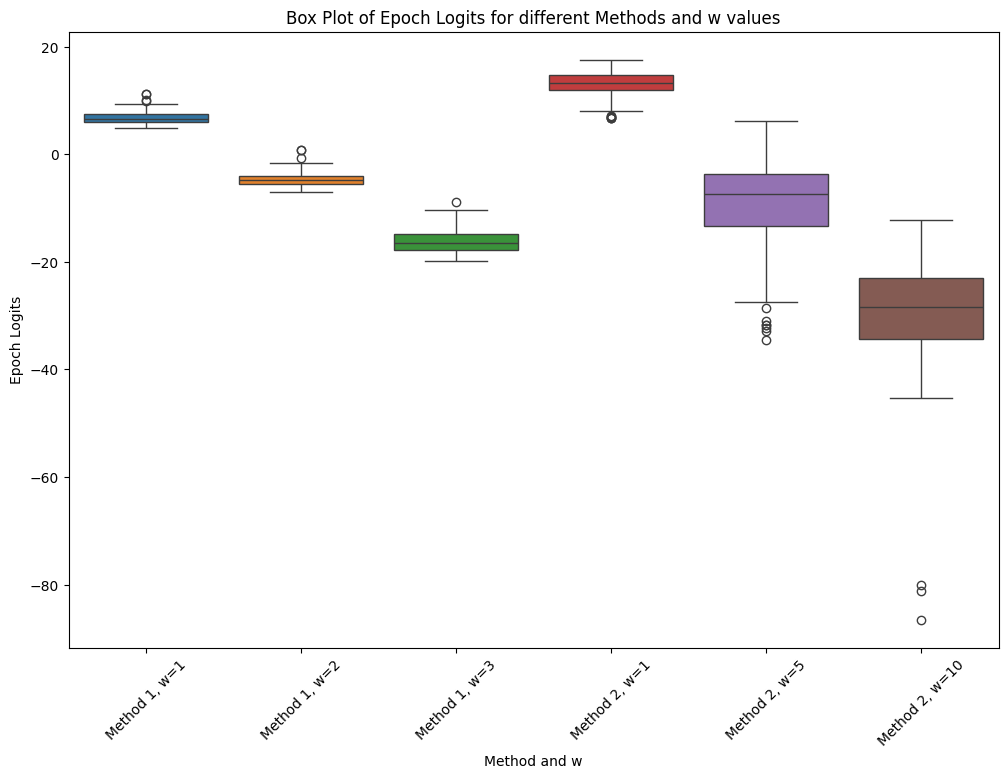

In [14]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=[data[key] for key in data.keys()])
plt.xticks(range(len(data)), list(data.keys()), rotation=45)
plt.xlabel('Method and w')
plt.ylabel('Epoch Logits')
plt.title('Box Plot of Epoch Logits for different Methods and w values')
plt.show()